In [1]:
# import libraries
import warnings
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings('ignore')

# for extraction of latitude & longitude
from geopy.geocoders import Nominatim 

# for models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

%matplotlib inline

### Let's Look at our data

In [2]:
data_file = 'data.csv'
data_file_req = 'data_req.csv'
data_file_with_lat_long = 'data-lat-long.csv'
data_file_processed = 'data-lat-long-req.csv'
df = pd.read_csv(data_file_processed, index_col=0)
df.head(3)

search_term                                            job_url  \
0  data scientist  /job/data-scientist-jabil-circuit-51ea2ce5b0ee...   
1  data scientist  /job/data-scientist-hewlett-packard-enterprise...   
2  data scientist  /job/data-scientist-smartsoft-c605a552bf2a0ae3...   

        job_title                         job_categories  \
0  Data Scientist  Information Technology, Manufacturing   
1  Data Scientist                            Consulting    
2  Data Scientist                 Information Technology   

                                job_location   job_employment_type  \
0     16 TAMPINES INDUSTRIAL CRESCENT 528604  Permanent, Full Time   
1                       1 DEPOT CLOSE 109841             Permanent   
2  INTERNATIONAL PLAZA, 10 ANSON ROAD 079903             Full Time   

      job_seniority job_last_posted_date         job_expiry_date  \
0         Executive   Posted 25 Jan 2019  Closing on 24 Feb 2019   
1      Professional   Posted 25 Jan 2019  Closing on 24 Feb 2019   
2  Senior Executive   Posted 25 Jan 2019  Closing on 24 Feb 2019   

                                     job_description     ...      \
0  JOB SUMMARY The Data Scientist I is a statisti...     ...       
1  Hewlett Packard Enterprise is an industry lead...     ...       
2  We are looking for highly motivated Individual...     ...       

  Job_senior_executive Job_senior_manager Job_senior_fresh/entry level  \
0                    0                  0                            0   
1                    0                  0                            0   
2                    0                  0                            0   

   Job_senior_senior executive  Job_senior_junior executive  \
0                            0                            0   
1                            0                            0   
2                            0                            0   

  Job_senior_professional Job_senior_middle management  \
0                       0                            0   
1                       0                            0   
2                       0                            0   

   Job_senior_non-executive   Latitude   Longitude  
0                         0   1.375230  103.929024  
1                         0  51.616574    7.323172  
2                         0        NaN         NaN  

[3 rows x 37 columns]

### EDA  

In [3]:
df.shape

(478, 37)

In [4]:
df.isnull().sum()/len(df) # determines whether we need to remove / impute null values before fitting into models.

search_term                     0.000000
job_url                         0.000000
job_title                       0.000000
job_categories                  0.000000
job_location                    0.000000
job_employment_type             0.000000
job_seniority                   0.000000
job_last_posted_date            0.000000
job_expiry_date                 0.000000
job_description                 0.000000
job_company_name                0.000000
job_company_info                0.031381
job_requirement                 0.000000
min_salary                      0.000000
max_salary                      0.000000
job_last_posted_date_new        0.000000
job_expiry_date_new             0.000000
count_days_urgency              0.000000
Job_ET_flexi work               0.000000
Job_ET_freelance                0.000000
Job_ET_part time                0.000000
Job_ET_contract                 0.000000
Job_ET_internship               0.000000
Job_ET_permanent                0.000000
Job_ET_temporary

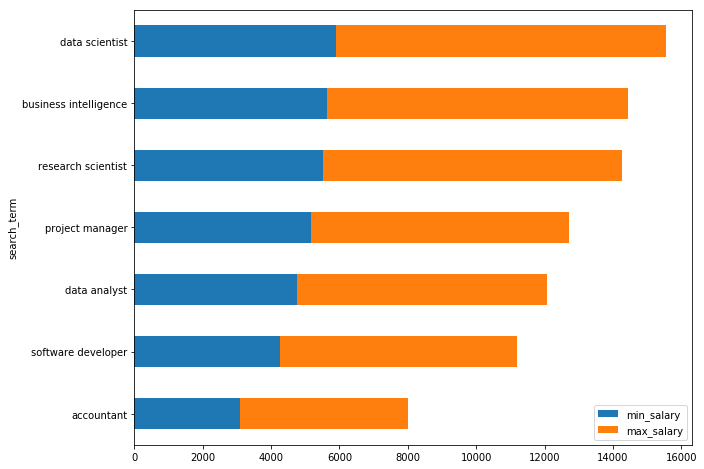

In [5]:
df_by_searchterm = df.groupby(by='search_term').mean()[['min_salary', 'max_salary']].sort_values(by='min_salary').plot(kind='barh', stacked=True, figsize=(10,8));

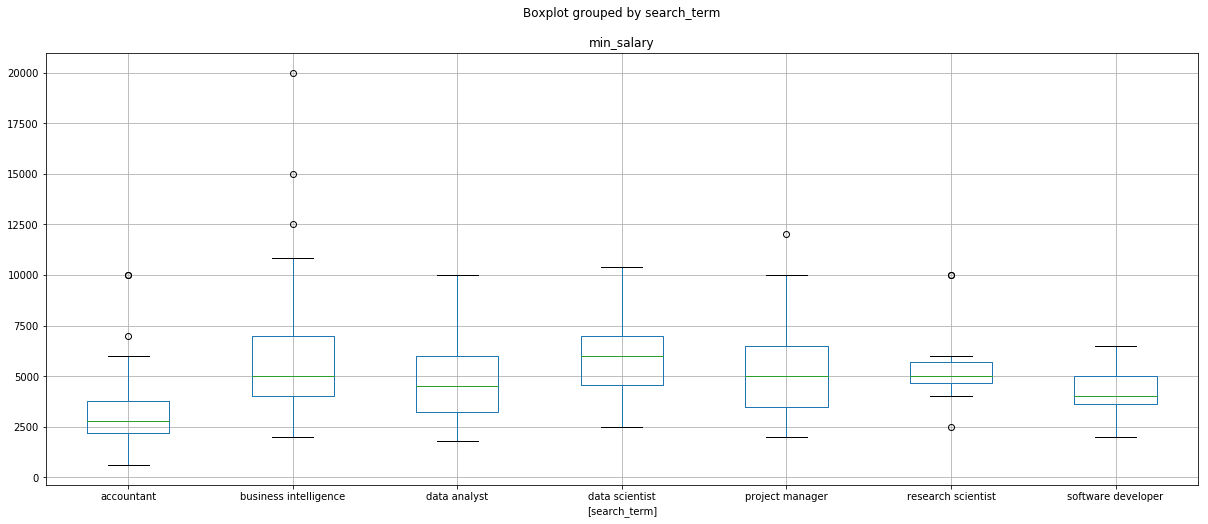

In [6]:
# as normally when applicants enter a new job, we get the "minimum salary". Let's look closer on this.
df[['search_term', 'min_salary']].boxplot(by='search_term', figsize=(20,8));

#### From the box plot above, we can observe that the job with highest median salary is data scientist followed by business intelligence.

In [7]:
# Feature Engineering - 
# Get number of days from time posted to time expiry (to determine "urgency")

df_clean = df[~df.job_location.isnull()]
def extract_date(x, text):
    try:
        return datetime.strptime(x.split(text)[1].strip(), '%d %b %Y')
    except:
        return np.NaN

def count_days(x):
    try:
        return int(str(x.job_expiry_date_new-x.job_last_posted_date_new).split('days')[0])
    except:
        return np.NaN

df_clean['job_last_posted_date_new'] = df_clean.job_last_posted_date.map(lambda x:extract_date(x,'Posted'))
df_clean['job_expiry_date_new'] = df_clean.job_expiry_date.map(lambda x:extract_date(x,'Closing on'))

df_clean['count_days_urgency'] = df_clean[['job_last_posted_date_new','job_expiry_date_new']].apply(count_days, axis=1)
df_clean[['job_last_posted_date','job_expiry_date', 'job_last_posted_date_new','job_expiry_date_new', 'count_days_urgency']].head()

job_last_posted_date         job_expiry_date job_last_posted_date_new  \
0   Posted 25 Jan 2019  Closing on 24 Feb 2019               2019-01-25   
1   Posted 25 Jan 2019  Closing on 24 Feb 2019               2019-01-25   
2   Posted 25 Jan 2019  Closing on 24 Feb 2019               2019-01-25   
3   Posted 25 Jan 2019  Closing on 24 Feb 2019               2019-01-25   
4   Posted 25 Jan 2019  Closing on 24 Feb 2019               2019-01-25   

  job_expiry_date_new  count_days_urgency  
0          2019-02-24                  30  
1          2019-02-24                  30  
2          2019-02-24                  30  
3          2019-02-24                  30  
4          2019-02-24                  30

In [8]:
# Feature Engineering - Dummy variables for search_term
df_clean = pd.concat([df_clean, pd.get_dummies(df_clean.search_term, prefix='job_searchterm')], axis=1)
df_clean.columns

Index(['search_term', 'job_url', 'job_title', 'job_categories', 'job_location',
       'job_employment_type', 'job_seniority', 'job_last_posted_date',
       'job_expiry_date', 'job_description', 'job_company_name',
       'job_company_info', 'job_requirement', 'min_salary', 'max_salary',
       'job_last_posted_date_new', 'job_expiry_date_new', 'count_days_urgency',
       'Job_ET_flexi work', 'Job_ET_freelance', 'Job_ET_part time',
       'Job_ET_contract', 'Job_ET_internship', 'Job_ET_permanent',
       'Job_ET_temporary', 'Job_ET_full time', 'Job_senior_senior management',
       'Job_senior_executive', 'Job_senior_manager',
       'Job_senior_fresh/entry level', 'Job_senior_senior executive',
       'Job_senior_junior executive', 'Job_senior_professional',
       'Job_senior_middle management', 'Job_senior_non-executive', 'Latitude',
       'Longitude', 'job_searchterm_accountant',
       'job_searchterm_business intelligence', 'job_searchterm_data analyst',
       'job_searchterm

30    460
14      5
29      4
Name: count_days_urgency, dtype: int64


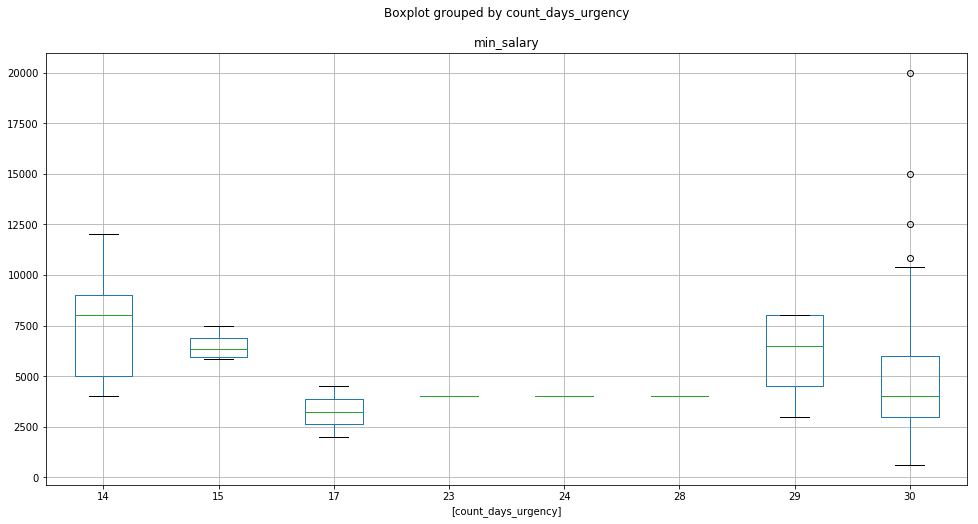

In [9]:
print(df_clean['count_days_urgency'].value_counts().head(3))
df_clean[['count_days_urgency', 'min_salary']].boxplot(by='count_days_urgency', figsize=(16,8));

#### Most job postings expire in 30 days.

In [10]:
# Feature Engineering - get multi-class label for job_employment_type

# get unique positions 
temp = [x.split(',') for x in df_clean.job_employment_type.unique()]
positions = []
for position in temp:
    positions.extend(position)
unique_positions = list(set([x.strip().lower() for x in positions]))

for position in unique_positions:
    df_clean['Job_ET_'+position] = df_clean.job_employment_type.map(lambda x:1 if position in x.lower() else 0)
    
df_clean[['job_employment_type'] + [x for x in df_clean.columns if 'Job_ET_' in x]].head() # sanity check.

job_employment_type  Job_ET_flexi work  Job_ET_freelance  \
0  Permanent, Full Time                  0                 0   
1             Permanent                  0                 0   
2             Full Time                  0                 0   
3             Full Time                  0                 0   
4             Full Time                  0                 0   

   Job_ET_part time  Job_ET_contract  Job_ET_internship  Job_ET_permanent  \
0                 0                0                  0                 1   
1                 0                0                  0                 1   
2                 0                0                  0                 0   
3                 0                0                  0                 0   
4                 0                0                  0                 0   

   Job_ET_temporary  Job_ET_full time  
0                 0                 1  
1                 0                 0  
2                 0                 1  
3                 0                 1  
4                 0                 1

In [11]:
# Feature Engineering - get multi-class label for job_seniority
df_clean = df_clean[~df_clean.job_seniority.isnull()]
# # get unique job_seniority 
temp = [x.lower().split(',') for x in df_clean.job_seniority.unique()]
seniority = []
for x in temp:
    seniority.extend(x)
unique_seniority = list(set([x.strip() for x in seniority]))
print(unique_seniority)

# output: ['fresh/entry level', 'middle management', 'junior executive',
#  'senior management', 'manager', 'senior executive', 'executive', 'non-executive', 'professional']

# seniority
# 1: 'fresh/entry level','junior executive'
# 2: 'non-executive', 'professional', 'manager',middle management, 'executive',
# 3: 'senior management', 'senior executive'
junior = ['fresh/entry level','junior executive']
senior = ['senior management', 'senior executive']

# management or executive or not 
# 1: 'junior executive' ,'executive', 'senior executive'
# 2: 'fresh/entry level', 'non-executive', 'professional', 
# 3: 'senior management', 'manager',middle management,
management = ['senior management', 'manager', 'middle management']
executive = ['junior executive' ,'executive', 'senior executive']

tmp = {
    'junior': junior,
    'senior': senior,
    'management': management,
    'executive': executive,
}
for position in tmp.items():
    df_clean['Job_seniority_'+position[0]] = df_clean.job_seniority.map(lambda x:1 if x.lower() in position[1] else 0)

tmp = {

}
for position in tmp.items():
    df_clean['Job_senjun_'+position[0]] = df_clean.job_seniority.map(lambda x:1 if x.lower() in position[1] else 0)

    
df_clean[['job_seniority'] + [x for x in df_clean.columns if 'Job_seniority_' in x]].head() # sanity check.

['non-executive', 'manager', 'junior executive', 'executive', 'fresh/entry level', 'middle management', 'senior management', 'professional', 'senior executive']


job_seniority  Job_seniority_junior  Job_seniority_senior  \
0         Executive                     0                     0   
1      Professional                     0                     0   
2  Senior Executive                     0                     1   
3  Senior Executive                     0                     1   
4  Senior Executive                     0                     1   

   Job_seniority_management  Job_seniority_executive  
0                         0                        1  
1                         0                        0  
2                         0                        1  
3                         0                        1  
4                         0                        1

In [12]:
# # feature engineering - Latitude & Longitude
# def get_lat_long(location):
#     if ',' in str(location):
#         location = location.split(',')[1]
#     try:
#         geolocator = Nominatim(user_agent='GA Project 4')
#         location_p = geolocator.geocode(location)
#         print(location)
#         print((location_p.latitude, location_p.longitude))
#         return location_p.latitude, location_p.longitude
#     except:
#         return None, None

# lat_long = df_clean.job_location.map(get_lat_long)
# df_clean['Latitude'] = pd.DataFrame(lat_long).apply(lambda x: x[0][0], axis=1)
# df_clean['Longitude'] = pd.DataFrame(lat_long).apply(lambda x: x[0][1], axis=1)
# df_clean.to_csv('data-lat-long-req.csv') # as this process takes a long time, we save it to data-lat-long.csv

In [13]:
# Feature Engineering - get multi-class label for job_seniority
df_clean = df_clean[~df_clean.job_categories.isnull()]
df_clean = df_clean[~df_clean.Latitude.isnull()]
# # get unique job_seniority 
temp = [x.lower().replace('/','_').replace(' ','').split(',') for x in df_clean.job_categories.unique()]
seniority = []
for x in temp:
    seniority.extend([y for y in x])
unique_seniority = list(set([x.strip() for x in seniority]))
print(unique_seniority)
for position in unique_seniority:
    df_clean['job_cat_'+position] = df_clean.job_categories.map(lambda x:1 if position in x.lower() else 0)
    
df_clean[['job_categories'] + [x for x in df_clean.columns if 'job_cat_' in x]].head() # sanity check.

['admin_secretarial', 'repairandmaintenance', 'travel_tourism', 'consulting', 'legal', 'sciences_laboratory_r&d', 'professionalservices', 'manufacturing', 'securityandinvestigation', 'sales_retail', 'generalmanagement', 'marketing_publicrelations', 'buildingandconstruction', 'accounting_auditing_taxation', 'architecture_interiordesign', 'healthcare_pharmaceutical', 'informationtechnology', 'advertising_media', 'others', 'riskmanagement', 'bankingandfinance', 'logistics_supplychain', 'engineering', 'customerservice', 'purchasing_merchandising', 'hospitality', 'telecommunications']


job_categories  job_cat_admin_secretarial  \
0  Information Technology, Manufacturing                          0   
1                            Consulting                           0   
3                 Information Technology                          0   
4                 Information Technology                          0   
6                                 Others                          0   

   job_cat_repairandmaintenance  job_cat_travel_tourism  job_cat_consulting  \
0                             0                       0                   0   
1                             0                       0                   1   
3                             0                       0                   0   
4                             0                       0                   0   
6                             0                       0                   0   

   job_cat_legal  job_cat_sciences_laboratory_r&d  \
0              0                                0   
1              0                                0   
3              0                                0   
4              0                                0   
6              0                                0   

   job_cat_professionalservices  job_cat_manufacturing  \
0                             0                      1   
1                             0                      0   
3                             0                      0   
4                             0                      0   
6                             0                      0   

   job_cat_securityandinvestigation             ...              \
0                                 0             ...               
1                                 0             ...               
3                                 0             ...               
4                                 0             ...               
6                                 0             ...               

   job_cat_advertising_media  job_cat_others  job_cat_riskmanagement  \
0                          0               0                       0   
1                          0               0                       0   
3                          0               0                       0   
4                          0               0                       0   
6                          0               1                       0   

   job_cat_bankingandfinance  job_cat_logistics_supplychain  \
0                          0                              0   
1                          0                              0   
3                          0                              0   
4                          0                              0   
6                          0                              0   

   job_cat_engineering  job_cat_customerservice  \
0                    0                        0   
1                    0                        0   
3                    0                        0   
4                    0                        0   
6                    0                        0   

   job_cat_purchasing_merchandising  job_cat_hospitality  \
0                                 0                    0   
1                                 0                    0   
3                                 0                    0   
4                                 0                    0   
6                                 0                    0   

   job_cat_telecommunications  
0                           0  
1                           0  
3                           0  
4                           0  
6                           0  

[5 rows x 28 columns]

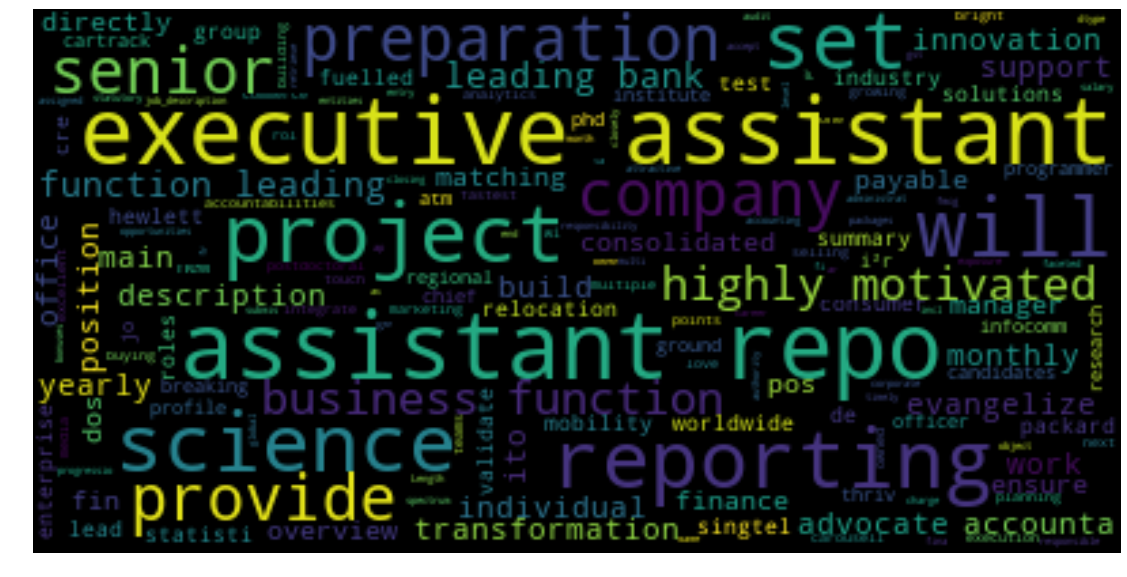

In [14]:
from wordcloud import WordCloud, STOPWORDS
stopwords= set(STOPWORDS)
stopwords.update(["job", "account", "reports", "role", "responsibilities", "looking", 'handle','data scientist', 'full', 'accounts', 'data', 'accountant', 'scientist'])
wc = WordCloud(stopwords=stopwords)
wc.generate_from_text(str(df_clean.job_description.map(lambda x:x.lower())))
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [62]:
skills = [
    'python', 'machine learning', 'sql', 'mobile', 'leading', 'worldwide'
    'visual', 'php', 'degree', 'accounts', 'accounts assistant', 'executive',
    'manager', 'innovation', 'reporting', 'assistant', 'bank', 'data'
 ]
for skill in skills:
    df_clean['skill_in_'+skill] = df_clean.job_description.map(lambda x:1 if skill in x.lower() else 0)
    print(df_clean['skill_in_'+skill].value_counts())


0    326
1     22
Name: skill_in_python, dtype: int64
0    309
1     39
Name: skill_in_machine learning, dtype: int64
0    328
1     20
Name: skill_in_sql, dtype: int64
0    337
1     11
Name: skill_in_mobile, dtype: int64
0    298
1     50
Name: skill_in_leading, dtype: int64
0    348
Name: skill_in_worldwidevisual, dtype: int64
0    348
Name: skill_in_php, dtype: int64
0    339
1      9
Name: skill_in_degree, dtype: int64
0    275
1     73
Name: skill_in_accounts, dtype: int64
0    328
1     20
Name: skill_in_accounts assistant, dtype: int64
0    310
1     38
Name: skill_in_executive, dtype: int64
0    254
1     94
Name: skill_in_manager, dtype: int64
0    329
1     19
Name: skill_in_innovation, dtype: int64
0    251
1     97
Name: skill_in_reporting, dtype: int64
0    326
1     22
Name: skill_in_assistant, dtype: int64
0    294
1     54
Name: skill_in_bank, dtype: int64
1    217
0    131
Name: skill_in_data, dtype: int64


In [63]:
numerical_columns = []
for column_name in df_clean.columns:
    if df_clean[column_name].dtypes != object and df_clean[column_name].dtypes != 'datetime64[ns]':
        numerical_columns.append(column_name)

df_numerical = df_clean[numerical_columns]
df_numerical.head()

min_salary  max_salary  count_days_urgency  Job_ET_flexi work  \
0      3000.0      6000.0                  30                  0   
1      5100.0     10000.0                  30                  0   
3      6000.0     11000.0                  30                  0   
4      6000.0     11000.0                  30                  0   
6      5000.0      6500.0                  30                  0   

   Job_ET_freelance  Job_ET_part time  Job_ET_contract  Job_ET_internship  \
0                 0                 0                0                  0   
1                 0                 0                0                  0   
3                 0                 0                0                  0   
4                 0                 0                0                  0   
6                 0                 0                0                  0   

   Job_ET_permanent  Job_ET_temporary            ...             \
0                 1                 0            ...              
1                 1                 0            ...              
3                 0                 0            ...              
4                 0                 0            ...              
6                 1                 0            ...              

   skill_in_executive  skill_in_manager  skill_in_innovation  \
0                   0                 0                    0   
1                   0                 0                    1   
3                   0                 0                    0   
4                   0                 0                    0   
6                   0                 0                    0   

   skill_in_reporting  skill_in_assistant  skill_in_bank  skill_in_data  \
0                   0                   0              0              1   
1                   0                   0              0              1   
3                   0                   0              0              1   
4                   0                   0              0              1   
6                   0                   0              0              1   

   skill_in_data scientist  skill_in_leading  skill_in_worldwidevisual  
0                        1                 0                         0  
1                        1                 1                         0  
3                        0                 0                         0  
4                        0                 0                         0  
6                        1                 0                         0  

[5 rows x 79 columns]

In [64]:
X = df_numerical[[x for x in df_numerical.columns if x not in ['min_salary', 'max_salary']]]
y = df_numerical['min_salary']

y_median = y.median()
print('median min_salary is', y_median) # median min_salary is ~4k
y_above_median = y.map(lambda x: 1 if x>y_median else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y_above_median)

median min_salary is 4400.0


In [65]:
y_above_median.value_counts()/len(y_above_median)

1    0.5
0    0.5
Name: min_salary, dtype: float64

### QUESTION 1: Factors that impact salary

To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:
- NLP
- Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
- Ensemble methods and decision tree models
- SVM models

Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.

#### Do a simple model

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
model = RandomForestClassifier()
np.mean(cross_val_score(model, X, y_above_median, cv=10, scoring='roc_auc'))

0.6652505446623094

In [67]:
model = SVC()
np.mean(cross_val_score(model, X, y_above_median, cv=10, scoring='roc_auc'))

0.6451418257934982

In [68]:
from sklearn.metrics import SCORERS
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

### QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.

In [69]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [70]:
# What components of a job posting distinguish data scientists from other data jobs?
X = df_numerical[[x for x in df_numerical.columns if 'job_searchterm' not in x and 'skill_in_data scientist' not in x]]
y = df_numerical['job_searchterm_data scientist']

In [71]:
model = RandomForestClassifier()
print('random forest:', round(np.mean(cross_val_score(model, X, y, cv=10, scoring='roc_auc')), 3))

random forest: 0.869


In [72]:
from sklearn.svm import SVC
model = SVC()
np.mean(cross_val_score(model, X, y, cv=10, scoring='roc_auc'))

0.5224003831417625

In [73]:
# we choose random forest classifier since it performed much better than support vector machine.
model = RandomForestClassifier()
model.fit(X, y)
df_importance = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance']).sort_values(by='importance', ascending=False)
df_importance.head(10)
# these are the most important features in finding a data scientist job.
# It is interesting to note that skills such as Machine Learning, Data and python are the top requirements.

importance
skill_in_machine learning    0.194501
Longitude                    0.103773
max_salary                   0.097361
Latitude                     0.084187
min_salary                   0.076207
Job_ET_permanent             0.048515
skill_in_data                0.040105
skill_in_reporting           0.033932
Job_seniority_management     0.032703
skill_in_leading             0.031979

In [75]:
df_importance.head(10).sum() 

importance    0.743262
dtype: float64

In [76]:
# What features are important for distinguishing junior vs. senior positions?
df_numerical[[x for x in df_numerical.columns if 'Job_seniority' in x]].head()

Job_seniority_junior  Job_seniority_senior  Job_seniority_management  \
0                     0                     0                         0   
1                     0                     0                         0   
3                     0                     1                         0   
4                     0                     1                         0   
6                     0                     1                         0   

   Job_seniority_executive  
0                        1  
1                        0  
3                        1  
4                        1  
6                        1

In [77]:
df_1 = df_numerical[df_numerical.Job_seniority_junior == 1]
print(df_1.shape)
df_2 = df_numerical[df_numerical.Job_seniority_senior == 1]
print(df_2.shape)
df_temp = pd.concat([df_1, df_2], axis=0)

(32, 79)
(55, 79)


In [101]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
sampling_methods = [
    imblearn.over_sampling.SMOTE(random_state=42), 
    imblearn.over_sampling.ADASYN(random_state=42), 
    imblearn.over_sampling.RandomOverSampler(random_state=42), 
    imblearn.under_sampling.RandomUnderSampler(random_state=42)
]

for sampling_method in sampling_methods:
    y = df_temp['Job_seniority_junior']
    X = df_temp[[x for x in df_temp.columns if x not in ['Job_seniority_junior', 'Job_seniority_senior']]]

    print(sampling_method)
    X_res, y_res = sampling_method.fit_resample(X, y)

    model = RandomForestClassifier()
    print('random forest:', round(np.mean(cross_val_score(model, X_res, y_res, cv=10, scoring='roc_auc')), 3))

    model = SVC()
    print('SVM:', np.mean(cross_val_score(model, X_res, y_res, cv=10, scoring='roc_auc')))
    
    print('*'*50)

SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
   out_step='deprecated', random_state=42, ratio=None,
   sampling_strategy='auto', svm_estimator='deprecated')
random forest: 0.81
SVM: 0.6575555555555556
**************************************************
ADASYN(n_jobs=1, n_neighbors=5, random_state=42, ratio=None,
    sampling_strategy='auto')
random forest: 0.824
SVM: 0.5931666666666666
**************************************************
RandomOverSampler(random_state=42, ratio=None, return_indices=False,
         sampling_strategy='auto')
random forest: 0.856
SVM: 0.8266666666666668
**************************************************
RandomUnderSampler(random_state=42, ratio=None, replacement=False,
          return_indices=False, sampling_strategy='auto')
random forest: 0.629
SVM: 0.5347222222222221
**************************************************


In [102]:
# best results for predicting seniority is RandomOverSamplier, Random Forest (0.82)

from imblearn.over_sampling import RandomOverSampler

sampling_method = RandomOverSampler()
X_res, y_res = sampling_method.fit_resample(X, y)

model = RandomForestClassifier()
model.fit(X,y)
pd.DataFrame(model.feature_importances_, index=X.columns, columns=['roc_auc']).sort_values(by='roc_auc', ascending=False).head()
# these are the top coefficients to predict seniority. 

roc_auc
max_salary          0.196663
Longitude           0.123146
min_salary          0.113671
Latitude            0.104885
skill_in_assistant  0.043753

In [ ]:
# Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?